In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Define file paths - since the notebook is in the same directory as the data files
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'
links_path = 'links.csv'


# Load datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)



Missing values in each dataset:
Ratings: 0
Movies: 0
Tags: 0
Links: 8

Ratings statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Number of unique users: 610
Number of unique movies: 9724
Average ratings per user: 165.30
Average ratings per movie: 10.37


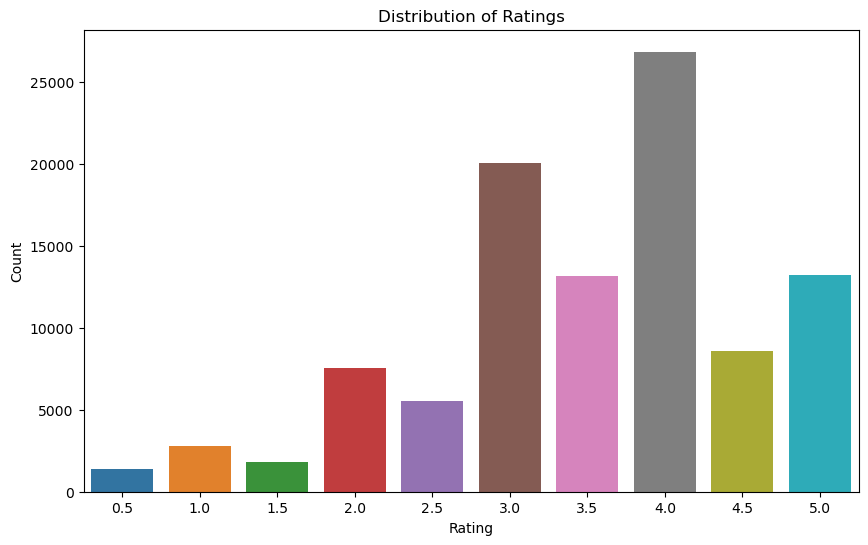

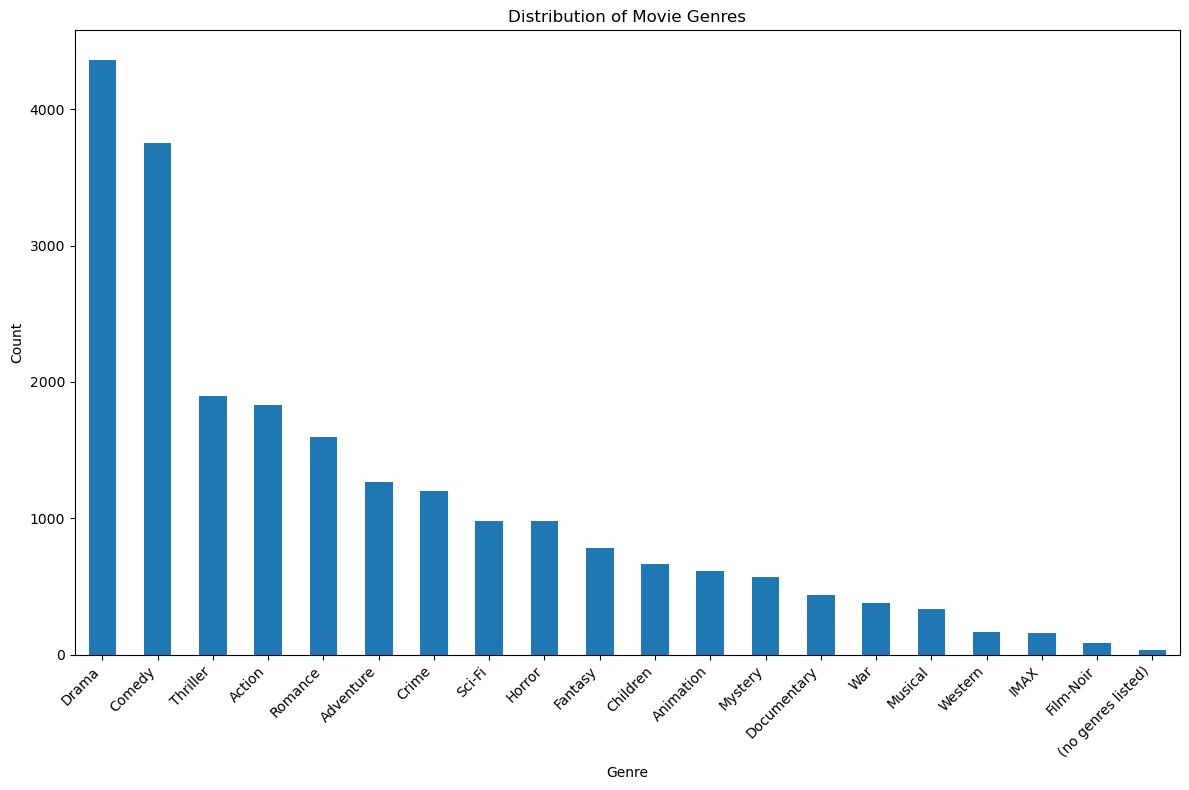

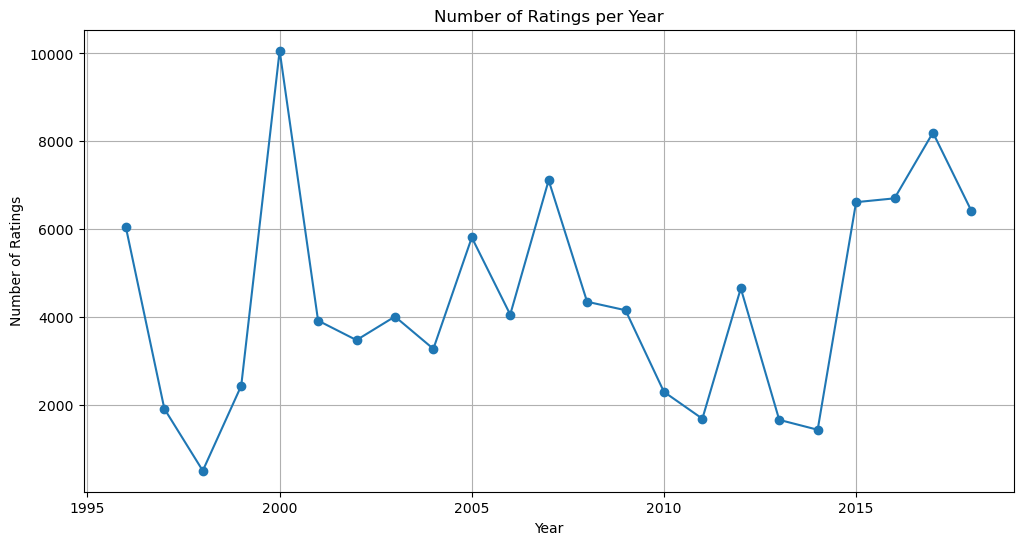

In [3]:
# Check for missing values
print("\nMissing values in each dataset:")
print(f"Ratings: {ratings.isnull().sum().sum()}")
print(f"Movies: {movies.isnull().sum().sum()}")
print(f"Tags: {tags.isnull().sum().sum()}")
print(f"Links: {links.isnull().sum().sum()}")

# Basic statistics for ratings
print("\nRatings statistics:")
print(ratings['rating'].describe())

# Count unique users and movies
unique_users = ratings['userId'].nunique()
unique_movies = ratings['movieId'].nunique()
print(f"\nNumber of unique users: {unique_users}")
print(f"Number of unique movies: {unique_movies}")
print(f"Average ratings per user: {ratings.shape[0]/unique_users:.2f}")
print(f"Average ratings per movie: {ratings.shape[0]/unique_movies:.2f}")

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Extract genres from the movies dataframe
genres = []
for genre_list in movies['genres'].str.split('|'):
    genres.extend(genre_list)
genre_counts = pd.Series(genres).value_counts()

plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year
yearly_ratings = ratings.groupby('year').size()

plt.figure(figsize=(12, 6))
yearly_ratings.plot(kind='line', marker='o')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

In [4]:
# Create a pivot table with users as rows, movies as columns, and ratings as values
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
print(f"User-item matrix shape: {user_movie_matrix.shape}")
print(f"Sparsity: {1 - (ratings.shape[0] / (user_movie_matrix.shape[0] * user_movie_matrix.shape[1])):.4f}")

'''
Cell 4 - Step 3: Implement Item-Based Collaborative Filtering
'''

# Fill NaN values with 0
user_movie_matrix_filled = user_movie_matrix.fillna(0)

# Calculate the cosine similarity between movies
print("Calculating movie similarities (this may take a while)...")
movie_similarity = cosine_similarity(user_movie_matrix_filled.T)
movie_similarity_df = pd.DataFrame(movie_similarity, 
                                  index=user_movie_matrix.columns, 
                                  columns=user_movie_matrix.columns)

# Function to get similar movies
def get_similar_movies(movie_id, n=10):
    if movie_id not in movie_similarity_df.index:
        return "Movie ID not found in the dataset"
    
    similar_movies = movie_similarity_df[movie_id].sort_values(ascending=False)
    similar_movies = similar_movies.drop(movie_id)  # Remove the movie itself
    
    similar_movies_df = pd.DataFrame({'movieId': similar_movies.index, 'similarity': similar_movies.values})
    similar_movies_info = pd.merge(similar_movies_df, movies, on='movieId')
    
    return similar_movies_info.head(n)

# Function to get movie recommendations for a user
def get_movie_recommendations(user_id, n=10):
    if user_id not in user_movie_matrix.index:
        return "User ID not found in the dataset"
    
    # Get movies the user has already rated
    user_ratings = user_movie_matrix.loc[user_id].dropna()
    
    # Initialize dictionary to store recommendations
    recommendations = {}
    
    # For each movie the user has rated
    for movie_id, rating in user_ratings.items():
        # Get similar movies
        similar_movies = movie_similarity_df[movie_id]
        
        # Weight similar movies by user rating
        weighted_movies = similar_movies * rating
        
        # Add to recommendations
        for similar_movie_id, score in weighted_movies.items():
            if similar_movie_id not in user_ratings.index:
                if similar_movie_id in recommendations:
                    recommendations[similar_movie_id] += score
                else:
                    recommendations[similar_movie_id] = score
    
    # Convert to DataFrame and sort
    recommendations_df = pd.DataFrame({
        'movieId': list(recommendations.keys()),
        'score': list(recommendations.values())
    })
    recommendations_df = recommendations_df.sort_values('score', ascending=False)
    
    # Merge with movie titles
    recommendations_with_titles = pd.merge(recommendations_df, movies, on='movieId')
    
    return recommendations_with_titles.head(n)

# Test item-based recommendations for a random user
random_user_id = ratings['userId'].sample(1).iloc[0]
print(f"Getting recommendations for user {random_user_id}:")
item_recommendations = get_movie_recommendations(random_user_id)
print(item_recommendations[['title', 'genres', 'score']])

User-item matrix shape: (610, 9724)
Sparsity: 0.9830
Calculating movie similarities (this may take a while)...
Getting recommendations for user 274:
                                               title  \
0                  E.T. the Extra-Terrestrial (1982)   
1                                 Vanilla Sky (2001)   
2                                       Rocky (1976)   
3                         Kiss Kiss Bang Bang (2005)   
4                                Garden State (2004)   
5                            Superman Returns (2006)   
6                           Road to Perdition (2002)   
7            Bill & Ted's Excellent Adventure (1989)   
8                         Blues Brothers, The (1980)   
9  Crouching Tiger, Hidden Dragon (Wo hu cang lon...   

                            genres        score  
0            Children|Drama|Sci-Fi  1000.767133  
1  Mystery|Romance|Sci-Fi|Thriller   996.872793  
2                            Drama   972.516092  
3    Comedy|Crime|Mystery|Thriller

In [5]:
# Apply SVD
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(user_movie_matrix_filled)

# Function to get recommendations using SVD
def get_svd_recommendations(user_id, n=10):
    if user_id not in user_movie_matrix.index:
        return "User ID not found in the dataset"
    
    # Get user vector
    user_vector = user_movie_matrix_filled.loc[user_id].values.reshape(1, -1)
    
    # Transform user vector to latent space
    user_latent = svd.transform(user_vector)
    
    # Reconstruct ratings from latent features
    reconstructed_ratings = svd.inverse_transform(user_latent)
    
    # Create DataFrame with predicted ratings
    predicted_ratings = pd.Series(reconstructed_ratings[0], index=user_movie_matrix.columns)
    
    # Get movies the user has already rated
    user_rated = user_movie_matrix.loc[user_id].dropna().index
    
    # Filter out already rated movies
    predicted_ratings = predicted_ratings.drop(user_rated)
    
    # Get top N recommendations
    top_recommendations = predicted_ratings.sort_values(ascending=False).head(n)
    
    # Get movie information
    recommended_movies = movies[movies['movieId'].isin(top_recommendations.index)].copy()
    recommended_movies['predicted_rating'] = recommended_movies['movieId'].map(top_recommendations)
    recommended_movies = recommended_movies.sort_values('predicted_rating', ascending=False)
    
    return recommended_movies

# Test SVD recommendations for the same user
print(f"Getting SVD recommendations for user {random_user_id}:")
svd_recommendations = get_svd_recommendations(random_user_id)
print(svd_recommendations[['title', 'genres', 'predicted_rating']])

Getting SVD recommendations for user 274:
                                                  title  \
941                                        Glory (1989)   
1469                                 Poltergeist (1982)   
7466                          King's Speech, The (2010)   
2983  Crouching Tiger, Hidden Dragon (Wo hu cang lon...   
2601                              Empire Records (1995)   
7647                        Crazy, Stupid, Love. (2011)   
328           Naked Gun 33 1/3: The Final Insult (1994)   
7302                    How to Train Your Dragon (2010)   
948                    Femme Nikita, La (Nikita) (1990)   
733                        It's a Wonderful Life (1946)   

                                         genres  predicted_rating  
941                                   Drama|War          1.359626  
1469                            Horror|Thriller          1.017193  
7466                                      Drama          0.798799  
2983                       Action|Dr

In [6]:
# Split data into training and testing sets
def evaluate_model():
    # Create a copy of the ratings dataframe
    ratings_copy = ratings.copy()
    
    # Split into training and testing sets
    train, test = train_test_split(ratings_copy, test_size=0.2, random_state=42)
    
    # Create user-item matrices for training data
    train_matrix = train.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
    
    # Apply SVD
    svd_model = TruncatedSVD(n_components=50, random_state=42)
    svd_model.fit(train_matrix)
    
    # Calculate RMSE
    predictions = []
    actuals = []
    
    for _, row in test.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        if user_id in train_matrix.index and movie_id in train_matrix.columns:
            # Get user vector
            user_vector = train_matrix.loc[user_id].values.reshape(1, -1)
            
            # Transform user vector to latent space
            user_latent = svd_model.transform(user_vector)
            
            # Reconstruct ratings from latent features
            reconstructed_ratings = svd_model.inverse_transform(user_latent)
            
            # Get predicted rating for the movie
            movie_idx = list(train_matrix.columns).index(movie_id)
            predicted_rating = reconstructed_ratings[0][movie_idx]
            
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f"RMSE: {rmse:.4f}")
    
    return rmse

# Evaluate the model
print("\nEvaluating the model...")
evaluate_model()



Evaluating the model...
RMSE: 3.1669


3.1668500054273365

In [ ]:
def interactive_recommender():
    print("\nWelcome to the Movie Recommender System!")
    print("1. Get recommendations based on a movie")
    print("2. Get recommendations for a user")
    choice = input("Enter your choice (1 or 2): ")
    
    if choice == '1':
        # Get movie recommendations
        movie_input = input("Enter a movie name: ")
        matching_movies = movies[movies['title'].str.contains(movie_input, case=False)]
        
        if len(matching_movies) == 0:
            print(f"No movies found matching '{movie_input}'")
            return
        
        print("\nMatching movies:")
        for i, (_, row) in enumerate(matching_movies.iterrows(), 1):
            print(f"{i}. {row['title']} ({row['genres']})")
        
        movie_idx = int(input("\nEnter the number of the movie you want: ")) - 1
        if movie_idx >= len(matching_movies):
            print("Invalid selection")
            return
        
        selected_movie_id = matching_movies.iloc[movie_idx]['movieId']
        n = int(input("Enter number of recommendations: "))
        
        similar_movies = get_similar_movies(selected_movie_id, n)
        print(f"\nTop {n} movies similar to '{matching_movies.iloc[movie_idx]['title']}':")
        for i, (_, row) in enumerate(similar_movies.iterrows(), 1):
            print(f"{i}. {row['title']} (Similarity: {row['similarity']:.4f})")
    
    elif choice == '2':
        # Get user recommendations
        try:
            user_id = int(input("Enter user ID: "))
            if user_id not in user_movie_matrix.index:
                print(f"User ID {user_id} not found in the dataset")
                return
            
            method = input("Choose recommendation method (1: Item-based, 2: SVD): ")
            n = int(input("Enter number of recommendations: "))
            
            if method == '1':
                recommendations = get_movie_recommendations(user_id, n)
                print(f"\nTop {n} recommendations for user {user_id} (Item-based):")
                for i, (_, row) in enumerate(recommendations.iterrows(), 1):
                    print(f"{i}. {row['title']} (Score: {row['score']:.4f})")
            
            elif method == '2':
                recommendations = get_svd_recommendations(user_id, n)
                print(f"\nTop {n} recommendations for user {user_id} (SVD-based):")
                for i, (_, row) in enumerate(recommendations.iterrows(), 1):
                    print(f"{i}. {row['title']} (Predicted rating: {row['predicted_rating']:.2f})")
            
            else:
                print("Invalid method selection")
        
        except ValueError:
            print("Invalid input. Please enter a valid user ID and number of recommendations.")
    
    else:
        print("Invalid choice")

# Run the interactive recommender
print("\nStarting the interactive recommender system...")
interactive_recommender() 


Starting the interactive recommender system...

Welcome to the Movie Recommender System!
1. Get recommendations based on a movie
2. Get recommendations for a user
Enter your choice (1 or 2): 1
Enter a movie name: memento

Matching movies:
1. Memento (2000) (Mystery|Thriller)
